In [43]:
import random
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%run TSP.ipynb
%matplotlib inline

In [44]:
class Ponto:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __repr__(self):
        return "({},{})".format(str(self.x), str(self.y))
    
    def distancia(self, ponto):
        xd = abs(self.x - ponto.x)
        yd = abs(self.y - ponto.y)
        return np.sqrt((xd ** 2) + (yd ** 2)).astype(int)

In [45]:
class Fitness:
    def __init__(self, rota):
        self.rota = rota
        self.fitness = 0
        self.distancia = 0
    
    def percorrerRota(self):
        if self.distancia == 0:
            distanciaPercorrida = 0
            for i in range(0, len(self.rota)):
                pontoA = self.rota[i]
                pontoB = None
                if i + 1 < len(self.rota):
                    pontoB = self.rota[i + 1]
                else:
                    pontoB = self.rota[0]
                distanciaPercorrida += pontoA.distancia(pontoB)
            self.distancia = distanciaPercorrida
        return self.distancia
    
    def getFitnessRota(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.percorrerRota())
        return self.fitness

In [46]:
# Retorna novo individuo
def criarRota(pontos):
    rota = random.sample(pontos, len(pontos))
    return rota

In [47]:
# Retorna lista de individuos
def inicializaPopulacao(tamanhoPopulacao, pontos):
    populacao = []
    for i in range(0, tamanhoPopulacao):
        populacao.append(criarRota(pontos))
    return populacao

In [48]:
# Retorna Dicionário ordenado por fitness
def rankInidividuos(populacao):
    fitness = {}
    for i in range(0,len(populacao)):
        fitness[i] = Fitness(populacao[i]).getFitnessRota()
    return sorted(fitness.items(), key = operator.itemgetter(1), reverse = True)

In [49]:
# Seleção Proporcional(Roleta)
# Retorna lista de indices dos individuos selecionados
def selecao(rankPopulacao, numEleitos):
    selecionados = []
    
    # Cria DataFrame
    df = pd.DataFrame(np.array(rankPopulacao), columns=["Indice","Fitness"])
    
    # Realiza Soma Acumulativa
    df['Soma_Acumulativa'] = df.Fitness.cumsum()
    
    # Calcula Percentual de aptidão
    df['Percentual'] = 100 * df.Soma_Acumulativa / df.Fitness.sum()
    
    # Seleciona eleitos
    for i in range(0, numEleitos):
        selecionados.append(rankPopulacao[i][0])
        
    # Seleção Proporcional
    for i in range(0, len(rankPopulacao) - numEleitos):
        
        # Roda roleta
        pontera = 100 * random.random()
        
        # Seleciona primeiro individuo apontado
        for i in range(0, len(rankPopulacao)):
            if pontera <= df.iat[i,3]:
                selecionados.append(rankPopulacao[i][0])
                break
                
    return selecionados

In [50]:
# Retorna lista de individuos
def getProcriadores(populacao, selecionados):
    procriadores = []
    for i in range(0, len(selecionados)):
        indice = selecionados[i]
        procriadores.append(populacao[indice])
    return procriadores

In [51]:
# +/- order crossover operator (OX1 ou OX)
def procriar(pai, mae):
    filho_DNA = []
    p1_DNA = []
    p2_DNA = []
    
    # Determina genes do pai que serão passados para o filho
    geneA = int(random.random() * len(pai))
    geneB = int(random.random() * len(pai))
    
    inicioGene = min(geneA, geneB)
    fimGene = max(geneA, geneB)

    # Adicio pedaço do DNA do Pai para o filho
    for i in range(inicioGene, fimGene):
        p1_DNA.append(pai[i])
    
    # Completa restantando do DNA com o da Mãe
    p2_DNA = [gene for gene in mae if gene not in p1_DNA]

    filho_DNA = p1_DNA + p2_DNA
    return filho_DNA

In [52]:
def procriaPopulacao(procriadores, numEleitos):
    filhos = []
    restantePopulacao = len(procriadores) - numEleitos
    pais = random.sample(procriadores, len(procriadores))

    # Passa eleitos para próxima geração
    for i in range(0, numEleitos):
        filhos.append(procriadores[i])
    
    # Preenche restante da população com filhos 
    for i in range(0, restantePopulacao):
        filho = procriar(pais[i], pais[len(procriadores)-i-1])
        filhos.append(filho)
    return filhos

In [53]:
# Mutação por troca
def mutar(dna, taxaMutacao):
    for i in range(len(dna)):
        if(random.random() < taxaMutacao):
            j = int(random.random() * len(dna))
            
            geneA = dna[i]
            geneB = dna[j]
            
            dna[i] = geneB
            dna[j] = geneA
    return dna

In [54]:
# Retorna população mutada
def mutarPopulacao(populacao, taxaMutacao):
    populacaoMutada = []
    
    for ind in range(0, len(populacao)):
        individuoMutado = mutar(populacao[ind], taxaMutacao)
        populacaoMutada.append(individuoMutado)
    return populacaoMutada

In [55]:
def proximaGeracao(populacao, numEleitos, taxaMutacao):
    # Ordena população conforme fitness
    rankPopulacao = rankInidividuos(populacao)
    
    # Realiza seleção dos melhor individuos
    selecionados = selecao(rankPopulacao, numEleitos)
    
    # Recupera individuos conforme indices selecionados
    procriadores = getProcriadores(populacao, selecionados)
    
    # Cria filhos a partir dos procriadores
    filhos = procriaPopulacao(procriadores, numEleitos)
    
    # Realiza mutação nos filhos
    proximaGeracao = mutarPopulacao(filhos, taxaMutacao)
    return proximaGeracao

In [56]:
def geneticAlgorithm(pontos, tamanhoPopulacao, numEleitos, taxaMutacao, geracoes):
    populacao = inicializaPopulacao(tamanhoPopulacao, pontos)
    print("Distancia Inicial: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    for i in range(0, geracoes):
        populacao = proximaGeracao(populacao, numEleitos, taxaMutacao)
    
    print("Distancia Final: " + str(1 / rankInidividuos(populacao)[0][1]))
    indiceMelhorRota = rankInidividuos(populacao)[0][0]
    melhorRota = populacao[indiceMelhorRota]
    return melhorRota

In [57]:
def geneticAlgorithmPlot(pontos, tamanhoPopulacao, numEleitos, taxaMutacao, geracoes):
    populacao = inicializaPopulacao(tamanhoPopulacao, pontos)
    progresso = []
    progresso.append(1 / rankInidividuos(populacao)[0][1])
    
    print("Distancia Inicial: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    for i in range(0, geracoes):
        populacao = proximaGeracao(populacao, numEleitos, taxaMutacao)
        progresso.append(1 / rankInidividuos(populacao)[0][1])
    
    print("Distancia Final: " + str(1 / rankInidividuos(populacao)[0][1]))
    
    plt.plot(progresso)
    plt.ylabel('Distancia')
    plt.xlabel('Geração')
    plt.show()

In [58]:
problem = TSP('eil51.tsp')

cityList = []

lista_ponto = list(problem.data.values())

for ponto in lista_ponto:
    cityList.append(Ponto(x=int(ponto[0]), y=int(ponto[1])))

Distancia Inicial: 1462.0
Distancia Final: 482.99999999999994


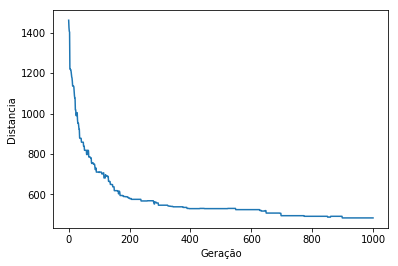

In [59]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.001, geracoes=1000)

Distancia Inicial: 1400.0
Distancia Final: 496.99999999999994


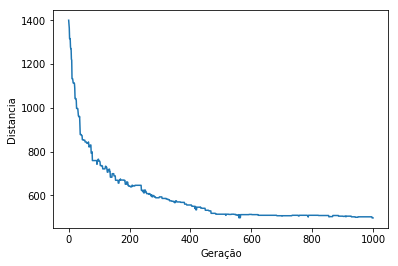

In [60]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.0025, geracoes=1000)

Distancia Inicial: 1410.0
Distancia Final: 523.0


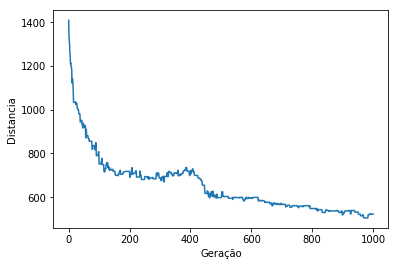

In [61]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.005, geracoes=1000)

In [ ]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.01, geracoes=1000)

In [ ]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.02, geracoes=1000)

In [ ]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.03, geracoes=1000)

In [ ]:
geneticAlgorithmPlot(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.04, geracoes=1000)

In [ ]:
#geneticAlgorithm(pontos=cityList, tamanhoPopulacao=100, numEleitos=20, taxaMutacao=0.01, geracoes=500)

In [ ]:
#cityList = []

#for i in range(0,25):
#    cityList.append(Ponto(x=int(random.random() * 200), y=int(random.random() * 200)))